# Yandex Workshop 2

## Мэтчинг товаров

Product Matching — это сравнение описаний товаров, полученных из разных источников (маркетплейсов, магазинов, отдельных продавцов и так далее), а матчер — инструмент, который этот процесс производит.

Зачем нам матчинг товарных позиций? Чтобы собирать одинаковые товары от разных продавцов — и попадать в ожидания покупателей.

## Импорты и инстоллы

Главная звезда проекта - библиотека FAISS.

In [1]:
pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 45.5 MB/s eta 0:00:00


Даже git lfs ругается на 2.3 ГБ csv-файл который пытаются пушнуть в репозиторий, так что я буду доставать его просто из gdrive. 

In [2]:
pip install gdown

In [3]:
import pandas as pd
import numpy as np
import requests
from io import StringIO

import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="darkgrid")

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import scipy
from scipy import stats as st

import faiss
import xgboost

import warnings
warnings.filterwarnings("ignore")

In [4]:
try:
    df_base = pd.read_csv('/home/aart/yandex_workshop2/yandex_workshop2/base.csv')
    df_train = pd.read_csv('/home/aart/yandex_workshop2/yandex_workshop2/train.csv')
    df_validation = pd.read_csv('/home/aart/yandex_workshop2/yandex_workshop2/validation.csv')
    df_validation_answer = pd.read_csv('/home/aart/yandex_workshop2/yandex_workshop2/validation_answer.csv')
except:
    url_train = "https://raw.githubusercontent.com/MarkvsLoopvs/yandex_workshop2/main/train.csv"
    url_validation = "https://raw.githubusercontent.com/MarkvsLoopvs/yandex_workshop2/main/validation.csv"
    url_validation_answer = \
    "https://raw.githubusercontent.com/MarkvsLoopvs/yandex_workshop2/main/validation_answer.csv"
    !gdown 'https://drive.google.com/uc?id=1FcPaLuUQ2PCWA4NevExVzX6UkEdfsZLw'
    !ls -l base.csv; du -sh base.csv
    df_base = pd.read_csv('./base.csv')
    df_train = pd.read_csv(url_train)
    df_validation = pd.read_csv(url_validation)
    df_validation_answer = pd.read_csv(url_validation_answer)

Downloading...
From (original): https://drive.google.com/uc?id=1FcPaLuUQ2PCWA4NevExVzX6UkEdfsZLw
From (redirected): https://drive.google.com/uc?id=1FcPaLuUQ2PCWA4NevExVzX6UkEdfsZLw&confirm=t&uuid=34ab6b61-7b9b-42e5-8ff0-02344770e5ef
To: /content/base.csv
100% 2.38G/2.38G [00:56<00:00, 42.1MB/s]
-rw-r--r-- 1 root root 2382100954 Jan 27 16:30 base.csv
2.3G	base.csv


# EDA

## info, head, пропуски

In [5]:
display(df_base.info(), df_base.head(), df_base.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      float64
 40  

None

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


Id    0
0     0
1     0
2     0
3     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 73, dtype: int64

Все признаки (72) численные, закодированные, без пропусков. Отдельно стоит отметить что csv-файл большого размера (2.9 млн строк)

In [6]:
display(df_train.info(), df_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

None

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


В тренировочных данных нет пропусков, все признаки из бейз на месте. Длина файла 100 тыс. строк

In [7]:
display(df_validation.info(), df_validation.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

None

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


Такой же случай.

In [8]:
display(df_validation_answer.info(), df_validation_answer.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Id        100000 non-null  object
 1   Expected  100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


None

,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


Пропусков нет, файл предоставлен для оценки модели по метрике `accuracy@5`.

## Дубликаты

In [9]:
display(df_train.duplicated().sum(), df_base.duplicated().sum(), df_validation.duplicated().sum())

0

0

0

Явных дубликатов нет.

## Описание признаков

Трудно изучать признаки, представленные лишь числами, но можно пытаться.

In [ ]:
df_base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


Метод `describe` сообщает нам, что значения признаков могут быть положительными и отрицательными, причем у разных признаков средним также могут быть отрицательные и положительные числа. А еще максимальные и минимальные значения могут иметь разрыв по модулю в несколько сотен.

# Препроцессинг

## Отбросим неинформативные столбцы `id`

In [11]:
train = df_train.drop(['Id','Target'], axis=1) #таргет убираем для масштабирования, потом смерджим обратно
base = df_base.drop('Id', axis=1)
valid = df_validation.drop('Id', axis=1)

## Масштабирование

Метод `describe` показал разницу по модулю в несколько сотен у отдельных признаков. Применим скейлер.

In [12]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
base_scaled = scaler.transform(base)
valid_scaled = scaler.transform(valid)

Мне кажется более правильным обучение скейлера на бейзе, но на моей локальной машине и в бесплатном пакете коллаба сразу умирает ядро от попытки это сделать, так что будет обучение на трейне.

## PCA

72 признака это тяжко для вычислительных мощностей, доступных обычному человеку. Проанализируем главные компоненты и уменьшим размерность.

In [13]:
pca = PCA(n_components=72)
pca.fit_transform(train_scaled)
var_ratio = pca.explained_variance_ratio_
var_ratio

array([0.01967671, 0.01777149, 0.01702246, 0.01695116, 0.0167618 ,
       0.01651845, 0.01637426, 0.01614752, 0.01613288, 0.01600915,
       0.01595853, 0.01582678, 0.01572159, 0.01555417, 0.01547869,
       0.01545639, 0.01534601, 0.0151753 , 0.01510577, 0.01500672,
       0.01491434, 0.01484183, 0.01471251, 0.01469489, 0.01460143,
       0.01453655, 0.01445038, 0.01428526, 0.01425044, 0.01418354,
       0.01416966, 0.01410729, 0.01403355, 0.01395248, 0.01389273,
       0.01385843, 0.01377029, 0.01373496, 0.01367291, 0.01361983,
       0.01356716, 0.01348129, 0.0134349 , 0.01341152, 0.01331817,
       0.01324691, 0.01319375, 0.01312498, 0.012968  , 0.01290531,
       0.01283831, 0.01273947, 0.01267938, 0.01254235, 0.0124938 ,
       0.01247833, 0.01240033, 0.01226313, 0.01222001, 0.01203959,
       0.01195938, 0.0118831 , 0.01180706, 0.01172572, 0.01159039,
       0.01137183, 0.01126407, 0.01115307, 0.01098732, 0.01083799,
       0.01052757, 0.00926666])

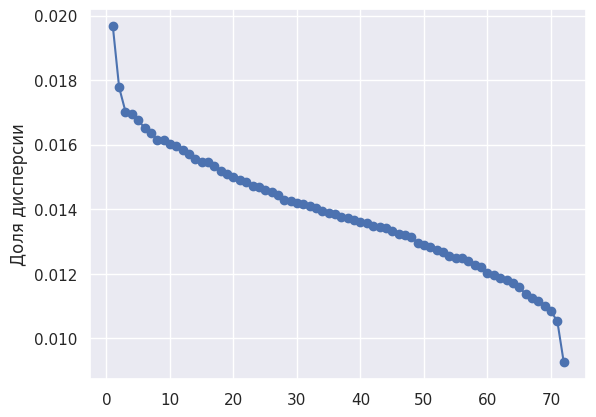

In [14]:
pc_numbers = np.arange(pca.n_components_) + 1

plt.plot(pc_numbers,
         var_ratio,
         'o-')
plt.ylabel('Доля дисперсии')
plt.show()

Имеем два очень важных признака (доли дисперсии ~0.018 и ~0.02) и один совсем не впечатляющий (<0.01). Попробуем отсечь 20 "худших" признаков.

In [15]:
pca = PCA(n_components=52)
pca.fit(train_scaled)

train_scaled_reduced = pca.transform(train_scaled)
base_scaled_reduced = pca.transform(base_scaled)
valid_scaled_reduced =  pca.transform(valid_scaled)

## Пишем функцию для вычисления метрики 

In [80]:
def acc_at_5(df):
    acc = 0
    for index, row in df.iterrows():
        if row['Target'] in row['Predicted']:
        acc+=1
    acc = acc * 100 / len(df)
    return acc

# FAISS

Faiss на трейне

In [77]:
%%time
d = 52
k = 5

nlist = 100
k = 5
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist)
assert not index.is_trained
index.train(base_scaled_reduced)
assert index.is_trained
index.add(base_scaled_reduced)

D, I = index.search(train_scaled_reduced, k)
dann = [df_base['Id'].loc[x] for x in I]

CPU times: user 1min 50s, sys: 1.27 s, total: 1min 52s
Wall time: 1min 17s


In [78]:
for i in range(len(I)):
    dann[i] = [df_base['Id'].loc[x] for x in I[i]]
train['Predicted'] = dann

In [79]:
df_train['Predicted'] = train['Predicted']

In [81]:
acc_at_5(df_train)

53.461

На тесте

In [67]:
%%time
d = 52
k = 5

nlist = 100
k = 5
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist)
assert not index.is_trained
index.train(base_scaled_reduced)
assert index.is_trained
index.add(base_scaled_reduced)

D, I = index.search(valid_scaled_reduced, k)
dann = [df_base['Id'].loc[x] for x in I]

CPU times: user 1min 48s, sys: 1.38 s, total: 1min 50s
Wall time: 1min 16s


In [68]:
for i in range(len(I)):
    dann[i] = [df_base['Id'].loc[x] for x in I[i]]
valid['Predicted'] = dann

In [69]:
df_validation['Predicted'] = valid['Predicted']

In [70]:
df_validation['Target'] = df_validation_answer['Expected']

In [71]:
acc_at_5(df_validation)

53.164

# Вывод

FAISS работает удовлетворительно для домашних мощностей и показыват 53.1 acc@5 на валидационной выборке. 
Идеи для дальнейшей работы над проектом: 
FAISS:
* Поиграть с гиперпараметрами. В итоговой версии проекта был выбрал довольно большой n_list, при его уменьшении можно улучшить acc@5 жертвуя временем работы 
* PAC анализ был довольно поверхностный, можно придумать что-то интересное там 

Другие идеи:
* Каждый товар представлен вектором фич. Может быть можно посмотреть что-то с cosine similarity, сделать это еще одной фичей для обучения, добиться чего-то таким образом